In [7]:
### IMPORTS TENSORFLOW ###

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D,  Flatten, MaxPooling2D, BatchNormalization , Dropout

### IMPORT METHOD FROM DATA PIPELINE ### 

In [6]:
### PARAMS ### 
path = 'Autonomous-ai/raw_data/*.jpg'


In [9]:
def init_model(target):
    model = Sequential()
    
    model = model.add(
        (Conv2D(32, (3, 3), activation= 'relu', input_shape= 256)),
        (BatchNormalization()),
        (MaxPooling2D((2, 2))),
        (Conv2D(64, (3, 3), activation= 'relu')),
        (BatchNormalization()),
        (MaxPooling2D((2, 2))),
        (Conv2D(64, (3, 3), activation= 'relu')),
        (BatchNormalization()),
        (MaxPooling2D((2, 2))),
        (Flatten()),
        (Dense(256, activation= 'relu')),
        (Dropout(.4)),
        (Dense(128, activation= 'relu')),
        (Dropout(.4)),
        Dense(target.shape[1], activation= 'softmax')
    )
        
    return model

In [11]:
def compile_model(model):
    model.compile( loss ='sparse_categorical_crossentropy',
                    optimizer='adam',
                    metrics = ['accuracy'])
    return model

In [4]:
### RL ### 
import gym
import random
import time
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image

from collections import namedtuple, deque
from itertools import count

### Pytorch Import ###
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
env = gym.make("CarRacing-v2", continuous= False, domain_randomize= True)

# Get actions space
n_actions = env.action_space.n

# Get the state of obs
state, info = env.reset()
n_obs = len(state)

In [6]:
img = Image.fromarray(state)

In [10]:
state.shape

(96, 96, 3)

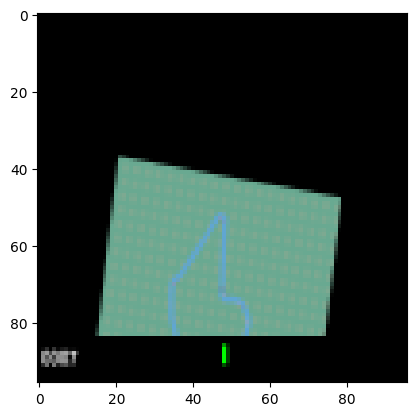

In [8]:
plt.imshow(img)

In [12]:
crop = state.copy()

In [36]:
cropp = crop[:84, 3:87]
cropp.shape

(84, 84, 3)

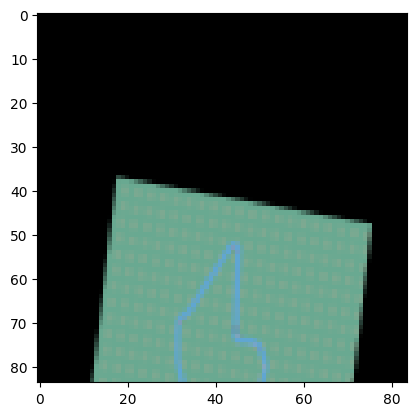

In [37]:
img_crop = Image.fromarray(cropp)
plt.imshow(img_crop)

In [38]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

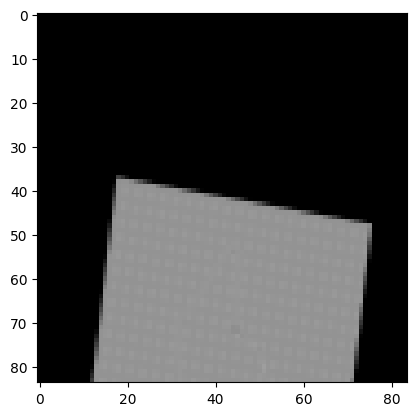

In [41]:
img_gray = rgb2gray(cropp)
img_gray = Image.fromarray(img_gray)
plt.imshow(img_gray)


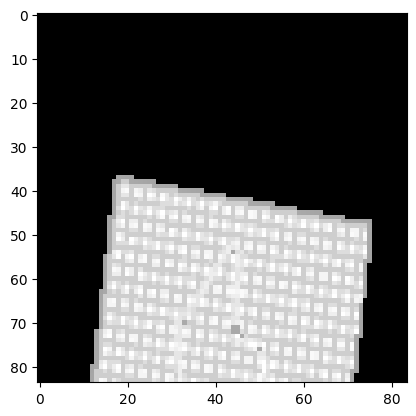

In [42]:
img_copy = np.copy(img_gray)

depth = 256
height, width = img_copy.shape

incidence = np.zeros((img_copy.size))
occurrence = np.zeros(depth)

k = 0
for i in range(height):
    for j in range(width):
        incidence[k] = img_copy[i, j]
        k = k + 1
count = 0

for j in range(len(incidence)):
    occurrence[int(incidence[j])] += 1

cummul = np.zeros(depth)
count = 0
for i in range(depth):
    count += occurrence[i]
    cummul[i] = count

const = (depth-1) / (height * width)

for i in range(depth):
    cummul[i] = round(cummul[i] * const, 0)

equalizer = np.copy(img_gray)
i1, j1 = np.nonzero(equalizer)

for j in range(len(i1)):
    equalizer[i1[j], j1[j]] = cummul[int(equalizer[i1[j], j1[j]])]

equalizer = equalizer.astype("uint8")
equalizer = np.stack((equalizer,) * 3, axis=-1)

plt.imshow(equalizer)
plt.show()

In [43]:
state

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [135]:
import torchvision.transforms.functional as TF
import torchvision.transforms as T

img = state.copy()
# img = TF.to_tensor(img)
img = TF.to_pil_image(img)

# scaler = T.Grayscale()
# img_gray = scaler(img)
img_gray = TF.to_grayscale(img)
# img_gray.shape

img_crop = TF.crop(img_gray, 0, 3, 84, 84)
# img_crop.shape

equalize_img = TF.equalize(img_crop)
# equalize_img.shape
state.shape, TF.to_tensor(equalize_img).shape
# torch.tensor(TF.to_tensor(equalize_img), dtype=torch.float32)


((96, 96, 3), torch.Size([1, 84, 84]))

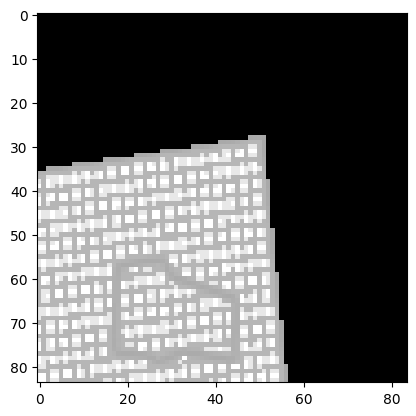

In [120]:
plt.imshow(equalize_img, cmap='gray')

In [141]:
def preprocessing_img(frame):
    # Convert to PIL
    img = TF.to_pil_image(frame)
    # Grayscale
    img_gray = TF.to_grayscale(img)
    # Crop
    img_crop = TF.crop(img_gray, 0, 3, 84, 84)
    # Equalize
    equalize_img = TF.equalize(img_crop)
    return TF.to_tensor(equalize_img)

In [142]:

# Get actions space
n_actions = env.action_space.n

# Get the state of obs
state, info = env.reset()
n_obs = len(preprocessing_img(state))

In [143]:
n_obs, n_actions

(1, 5)

In [144]:
state.shape

(96, 96, 3)

In [139]:
state = preprocessing_img(state)

In [145]:
9 * 9 * 24


1944

In [147]:
84 / 4


21.0

In [151]:
18 * 18

324